In [1]:
import scipy as sp
from scipy import io, stats
from scipy.special import psi, gammaln
from numpy.linalg import inv, det
import numpy as np


import matplotlib.pyplot as plt
from matplotlib import colors
import itertools
%matplotlib inline

In [6]:
class GMM(object):
    
    def EM_Init(self, n, d, k):
        self.pi = np.ones(k)
        self.mu = sp.random.random((k, d))
        self.lamb = np.zeros((d, k, d))
        for j in range(k):
            self.lamb[:,j,:]=np.diag(sp.random.random(d))       
        self.phi = sp.random.random((n, k))
        self.n = np.zeros(k)
        self.log_likehood = []
                
    def E_step(self):
        for i in range(self.N):
            marginal = 0
            for k in range(self.k):
                marginal += self.pi[k]*stats.multivariate_normal.pdf(self.X[i,:], mean=self.mu[k,:], cov=inv(self.lamb[:,k,:]))
            for j in range(self.k):
                self.phi[i,j]=self.pi[j]*stats.multivariate_normal.pdf(self.X[i,:], mean=self.mu[j,:], cov=inv(self.lamb[:,j,:]))/marginal
    
    def M_step(self):
        for j in range(self.k):
            self.n[j]=np.sum(self.phi[:,j],0)
            self.mu[j,:]=1.0/self.n[j] * np.sum(np.multiply(self.phi[:,j].reshape(self.N,1),self.X),0)
            s=0
            for i in range(self.N):
                xminusmu = self.X[i,:] - self.mu[j,:]
                xminusmu = xminusmu.reshape(self.d,1)
                s += self.phi[i,j] * np.dot(xminusmu, xminusmu.T)
            self.lamb[:,j,:] = inv(1.0 / self.n[j] * s)
            self.pi[j] = self.n[j] / self.N
    
    def loglikelihood(self):
        loglikelihood = 0
        for i in range(self.N):
            p_x = 0
            for k in range(self.k):
                p_x = p_x + self.pi[k] * stats.multivariate_normal.pdf(self.X[i,:], mean=self.mu[k,:], cov=inv(self.lamb[:,k,:]))
            loglikelihood += np.log(p_x)
        self.log_likehood.append(loglikelihood)
            
    def EM(self, k, X, T):
        self.k = k
        self.X = X
        self.N, self.d = X.shape
        self.EM_Init(n=self.N, d=self.d, k=self.k)
        for i in range(T):
            self.E_step()
            self.M_step()
            self.loglikelihood()
    
    def EM_plot_loglikelihood(self):
        fig = plt.figure(figsize=(12, 8))
        plt.plot(self.log_likehood)
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('Log Likelihood')
        plt.savefig('problem 1b k=%s' %self.k)
    
    def EM_scatter_plot(self):
        fig = plt.figure(figsize=(12, 8))
        cluster = [i.argmax() for i in self.phi]
        plt.scatter(X[:,0],X[:,1], c=cluster, s=100)
        plt.grid()
        fig.savefig('problem 1c k=%s' %self.k)
        
    def sample(self, X):
        s1 = sp.random.choice(X[:,0], 1)
        s2 = sp.random.choice(X[:,1], 1)
        return np.array((s1[0],s2[0]))

    def VI_Init(self):
        self.alpha = 1.0
        self.c = 10.0
        self.a = float(self.d) 
        self.B = (self.d /10.0)* np.cov(self.X.T)
        self.n_j = np.ones(self.K)
        self.a_j = sp.random.random(self.K) * 10
        self.sigma_j = [sp.random.random((self.d, self.d)) for i in range(self.K)]
        self.m_j = [self.sample(self.X) for i in range(self.K)]
        self.alpha_j = sp.random.random(self.K) * 10
        self.B_j = [np.diag(np.diag(self.B)) * sp.random.random(1) for i in range(self.K)]
        self.t1_j = np.zeros((self.n, self.K))
        self.t2_j = np.zeros((self.n, self.K))
        self.t3_j = np.zeros((self.n, self.K))
        self.t4_j = np.zeros((self.n, self.K))
        self.phi_ij = np.ones((self.n, self.K)) * (1.0 / self.K)
        self.cI = np.diag([float(1/self.c)] * self.d)
        self.objective = []
        
    def update_qc(self):
        for i, xi in enumerate(self.X):
            for j in range(self.K):
                xminusm = (xi - self.m_j[j]).reshape((self.d,1))
                self.t1_j[i,j] = np.sum([psi((float(k) + self.a_j[j])/2.0 ) for k in range(self.d)]) - np.log(det(self.B_j[j]))
                self.t2_j[i,j] = xminusm.T.dot((self.a_j[j] * inv(self.B_j[j]))).dot(xminusm)
                self.t3_j[i,j] = np.trace((self.a_j[j] * inv(self.B_j[j])).dot(self.sigma_j[j]))
                self.t4_j[i,j] = psi(self.alpha_j[j]) - psi(np.sum(self.alpha_j))
            num = np.zeros((self.n, self.K))
            denom = np.zeros((self.n,1))
            for j in range(self.K):
                num[:,j] = np.exp( 0.5 * self.t1_j[:,j] - 0.5 * self.t2_j[:,j] - 0.5 * self.t3_j[:,j] + self.t4_j[:,j])    
                denom += num[:,j].reshape((self.n,1))
            self.phi_ij = np.divide(num, denom)
        
    def calculate_objective(self):
        Eln_qpi = stats.dirichlet.entropy(self.alpha_j)
        Eln_qmu  = [stats.multivariate_normal.entropy(self.m_j[j], self.sigma_j[j]) for j in range(self.K)]
        Eln_qLambda= [stats.wishart.entropy(self.a_j[j], inv(self.B_j[j])) for j in range(self.K)]
        Eln_ppi=(self.alpha-1.0)*(psi(self.alpha_j) - psi(np.sum(self.alpha_j)))
        Eln_pmu=-0.5/self.c*np.asarray([np.trace(self.sigma_j[j])+self.m_j[j].dot(self.m_j[j]) for j in range(self.K)])
        Eln_Lambda=-np.log(det(self.B_j))+np.sum(psi((self.a_j.reshape(self.K,1)+1.0-np.arange(1,self.d+1))/2.0),1)
        Eln_pi=psi(self.alpha_j)-psi(np.sum(self.alpha_j))
        E_xmuLambda=np.zeros((self.n,self.K))
        for i, xi in enumerate(self.X):
            for j in range(self.K):
                    ximinusmj=(xi-self.m_j[j]).reshape(self.d,1)
                    E_xmuLambda[i,j]=ximinusmj.T.dot(self.a_j[j]*inv(self.B_j[j])).dot(ximinusmj)+np.trace(self.a_j[j]*inv(self.B_j[j]).dot(self.sigma_j[j]))
        Eln_pLambda=np.multiply(self.a_j-self.d-1.0,Eln_Lambda)/2.0-0.5*np.asarray([np.trace(self.B_j[j].dot(self.a_j[j]*inv(self.B_j[j]))) for j in range(self.K)])
        Eln_pxc=np.sum(np.multiply(self.phi_ij,0.5*Eln_Lambda+Eln_pi-0.5*E_xmuLambda),0)
        L=sum(Eln_ppi)+sum(Eln_pmu)+sum(Eln_pxc)+sum(Eln_pLambda)-Eln_qpi-sum(Eln_qmu)-sum(Eln_qLambda)
        self.objective.append(L)
    

    def VI(self, k, X, T):
        self.K = k
        self.n, self.d = X.shape
        self.X = X
        self.VI_Init()

        for t in range(T):
            self.update_qc()
            
            for j in range(self.K):
                self.n_j[j] = np.sum(self.phi_ij[:,j])
                self.alpha_j[j] = self.alpha + self.n_j[j]
                self.sigma_j[j] = inv(self.cI + (self.n_j[j] * self.a_j[j]) * inv(self.B_j[j]))   
                self.m_j[j] = self.sigma_j[j].dot(self.a_j[j] * inv(self.B_j[j]).dot(np.sum(self.phi_ij[:,j].reshape(self.n,1) * self.X, 0)))

            
            for j in range(self.K):
                bsum = 0.0
                for i, xi in enumerate(self.X):
                    xminusm = (xi - self.m_j[j]).reshape((self.d,1))
                    bsum += self.phi_ij[i,j] * (xminusm.dot(xminusm.T) + self.sigma_j[j])
                self.a_j[j] = self.a + self.n_j[j]
                self.B_j[j] = self.B + bsum
            
            self.calculate_objective()


            
    def VI_plot_objective(self):
        fig = plt.figure(figsize=(12, 8))
        plt.plot(self.objective)
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('Objective Function')
        plt.savefig('problem 2b k=%s' %self.K)
    
    def VI_scatter_plot(self):
        fig = plt.figure(figsize=(12, 8))
        cluster = [i.argmax() for i in self.phi_ij]
        plt.scatter(X[:,0],X[:,1], c=cluster, s=100)
        plt.grid()
        fig.savefig('problem 2c k=%s' %self.K)
        
    def Gibbs_update_posterior(self, X):
        s, d = X.shape
        xbar = np.mean(X,0)
        sum_xbarxT = 0
        for xi in X:
            xminusxbar = (xi - xbar).reshape(d,1)
            sum_xbarxT += xminusxbar.dot(xminusxbar.T)
        xmxbar = (xbar - self.m).dot((xbar - self.m).T)
        m_j = (self.c / (s + self.c)) * self.m + (1 / (s + self.c)) * np.sum(X,axis=0)
        c_j = s + self.c 
        a_j = s + self.a
        B_j = self.B + sum_xbarxT+ (s/(self.a * s + 1.0)) * xmxbar
        lambda_val = stats.wishart.rvs(a_j, inv(B_j))
        mu = stats.multivariate_normal.rvs(mean=m_j, cov=inv(c_j * lambda_val))
        return mu, lambda_val
    
    def Gibbs_Init(self):
        self.c = (1.0/10.0)
        self.a = float(self.d)
        self.B = self.c * float(self.d)* (np.cov(self.X.T))
        self.m = np.mean(self.X, axis=0)
        self.mu = [np.zeros(self.n) for i in range(self.n)]
        self.lambda_val = [np.zeros((self.n, self.n)) for i in range(self.n)]
        self.alpha =1.0
        self.c_i = np.zeros(self.n)
        self.phi_ij = np.zeros((self.n, self.n))
        self.phi_ij[:,0]=1.0
        self.mu[0], self.lambda_val[0] = self.Gibbs_update_posterior(self.X)
        
        
    def calculate_px(self, xi):
        c_ratio = self.c / (1.0 + self.c)
        t1 = (c_ratio / np.pi) ** (self.d / 2.0)
        xminusm = (xi - self.m).reshape(self.d, 1)
        t2 = det(self.B + c_ratio * (xminusm).dot(xminusm.T)) ** (-0.5 * (self.a + 1.0)) / det(self.B) ** (-0.5 * self.a)
        j = np.arange(self.d)
        t3 = np.exp(np.sum(gammaln((self.a + 1.0)/2.0 - j/2.0) - gammaln(self.a/2.0 - j/2.0)))
        return t1 * t2 * t3
    
    def Gibbs_Sampler(self, X, T=500):
        self.n, self.d=X.shape
        self.X = X
        self.Gibbs_Init()
        self.obspercluster = range(T)
        
        for t in range(T):
            self.phi_ij = np.zeros((self.n, self.n))
            for i, xi in enumerate(self.X):
                ntmp=np.asarray([len(np.where(self.c_i==z)[0]) if z != self.c_i[i] else len(np.where(self.c_i==z)[0]) - 1 for z in range(self.n)])
                n_j = np.where(ntmp>0)[0]
                for j in n_j:
                    self.phi_ij[i,j] = stats.multivariate_normal.pdf(xi, self.mu[j],inv(self.lambda_val[j])) * ntmp[j]/(self.alpha+self.n - 1)
                jprime=int(max(set(self.c_i))+1)
                p_xi = self.calculate_px(xi)
                self.phi_ij[i, jprime] = self.alpha / (self.alpha + self.n - 1) * p_xi
                self.phi_ij[i] = self.phi_ij[i] / np.sum(self.phi_ij[i])
                idx = np.where(self.phi_ij[i])[0]
                dirch_sample = stats.dirichlet.rvs(self.phi_ij[i][self.phi_ij[i]>0])
                self.c_i[i] = idx[np.argmax(dirch_sample)]
                if self.c_i[i] == jprime:
                    self.mu[jprime], self.lambda_val[jprime] = self.Gibbs_update_posterior(self.X[self.c_i==jprime])
            for k in set(self.c_i):
                self.mu[int(k)], self.lambda_val[int(k)] = self.Gibbs_update_posterior(self.X[self.c_i==k])
            self.obspercluster[t] = [np.sum(self.c_i==i) for i in set(self.c_i)]
#             if( (t+1)%10==0):
#                 print "There are", len(set(self.c_i)),"clusters at iteration",(t+1),'distributed as',self.obspercluster[t]
        for t in self.obspercluster:
            t.sort(reverse=True)
            
    def plot_ClusterCount(self):
        maxval =[]
        for i in self.obspercluster:
            maxval= max(np.max(len(i)), maxval)
        plotdf = np.zeros((len(self.obspercluster), maxval))
        for i, cvals in enumerate(self.obspercluster):
            for j, cnums in enumerate(cvals):
                plotdf[i,j] = cnums
        myplot = plt.figure(figsize=(12,8))
        plt.plot(plotdf)
        plt.title('Count of Obs per Cluster for Gibbs-Sampler')
        plt.xlabel('Iteration')    
        plt.ylabel('Number of Observations per cluster')
        plt.grid()
        myplot.savefig('problem 3B')


    def plot_TotalClusters(self):
        pltdf= [len(i) for i in self.obspercluster]
        myplot = plt.figure(figsize=(12,8))
        plt.plot(pltdf)
        plt.title('Total Number of Clusters for Gibbs-Sampler')
        plt.xlabel('Iteration')    
        plt.ylabel('Total Number of clusters')
        plt.grid()
        myplot.savefig('problem 3C')
        

        
        
        





    
             

In [3]:
dat = io.loadmat('data.mat')
X = dat['X'].T

In [49]:
for k in [2]:
    model = GMM()
    model.VI(k=k, X=X, T=100)
    obj = np.asarray(model.objective)
    np.savetxt('VI_Objective' + str(k) + '.txt', obj)
    cluster = np.asarray([i.argmax() for i in model.phi_ij])
    np.savetxt('VI_cluster' + str(k) + '.txt', cluster)

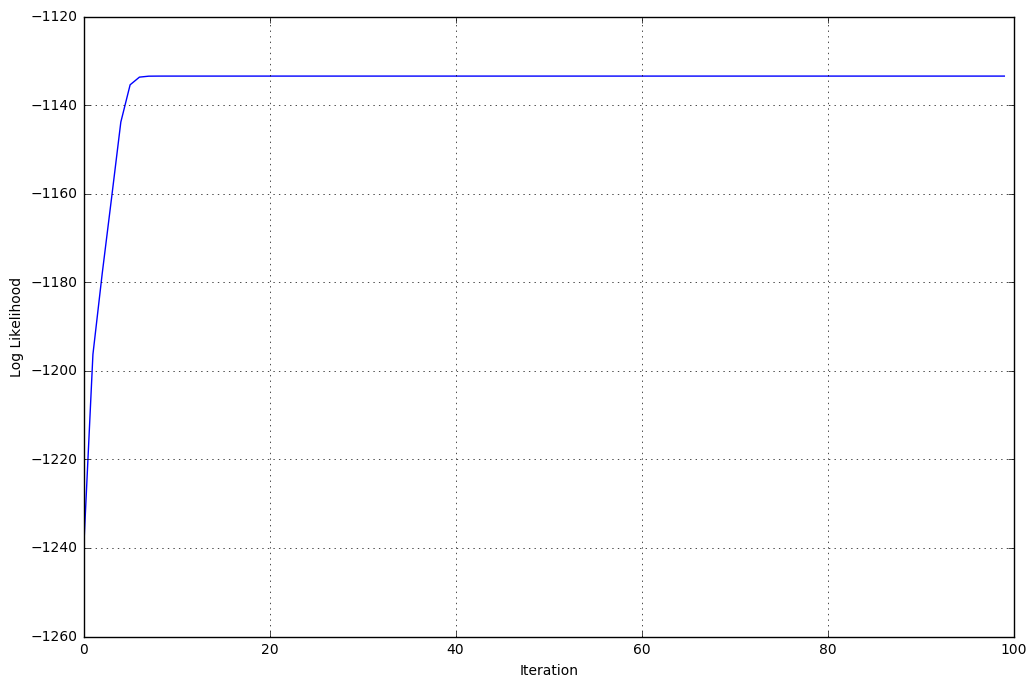

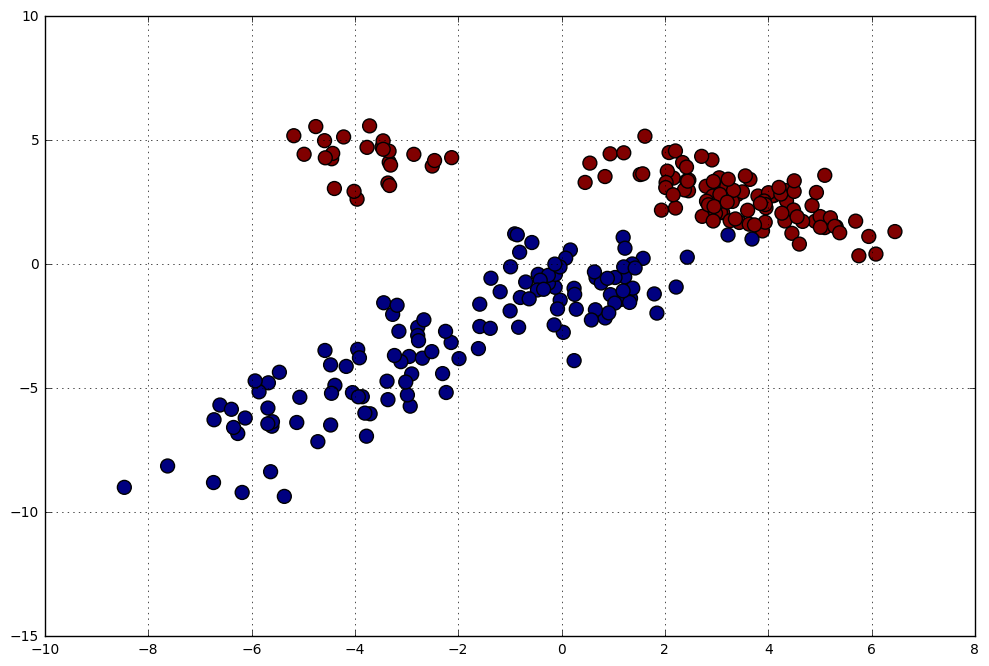

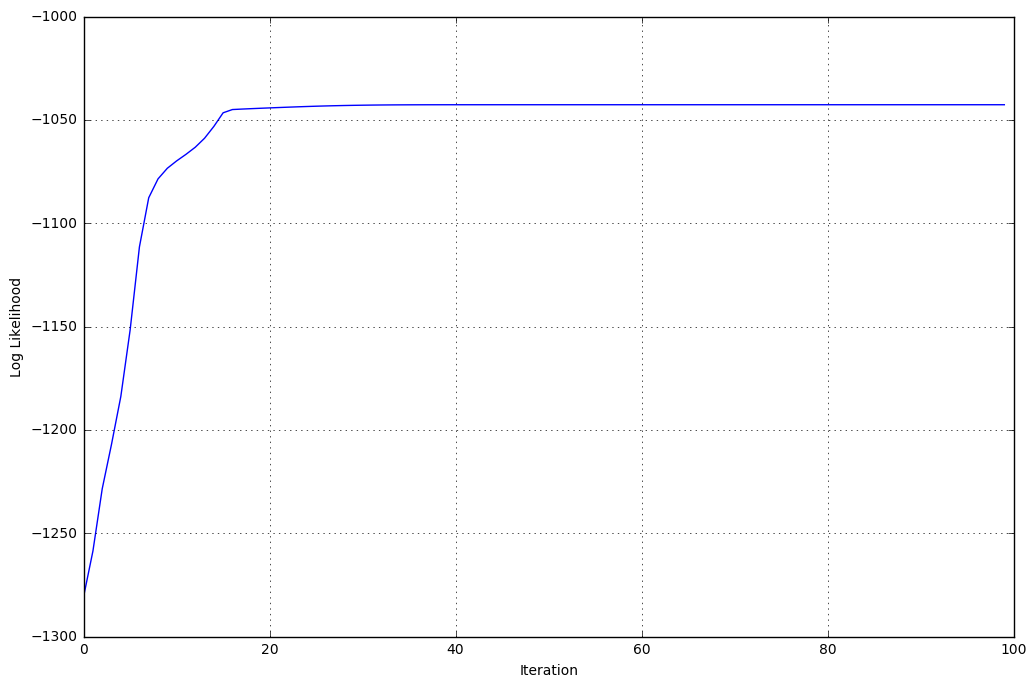

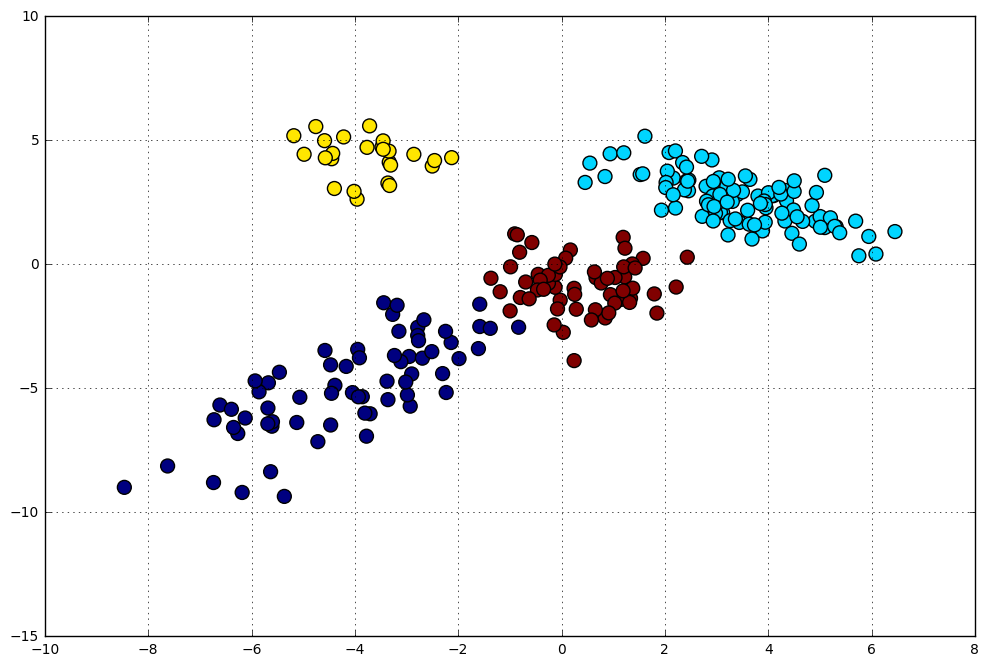

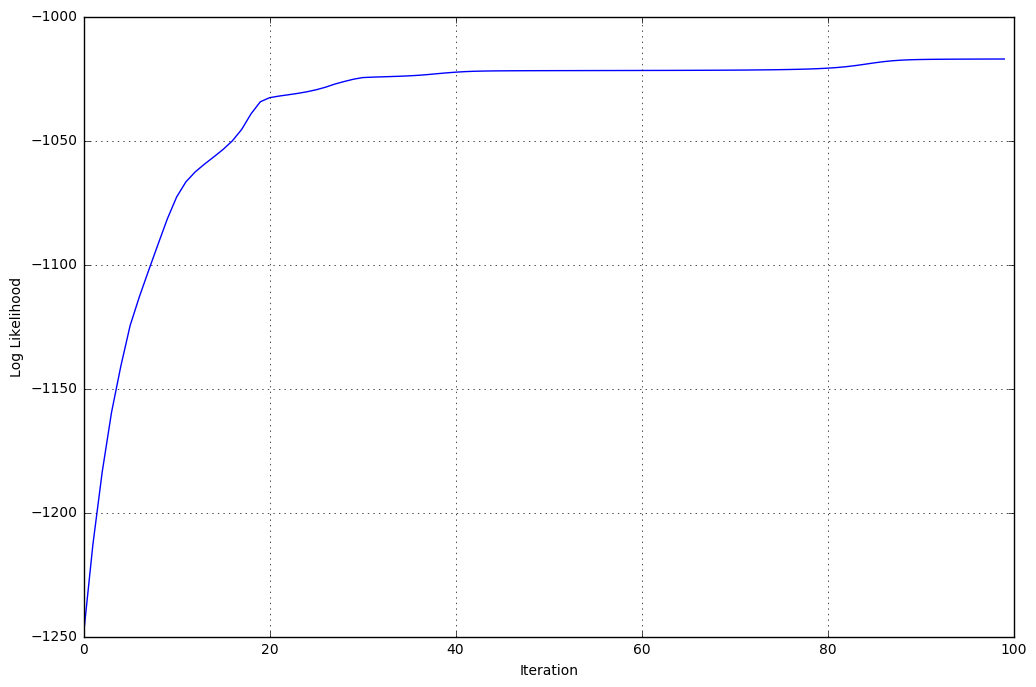

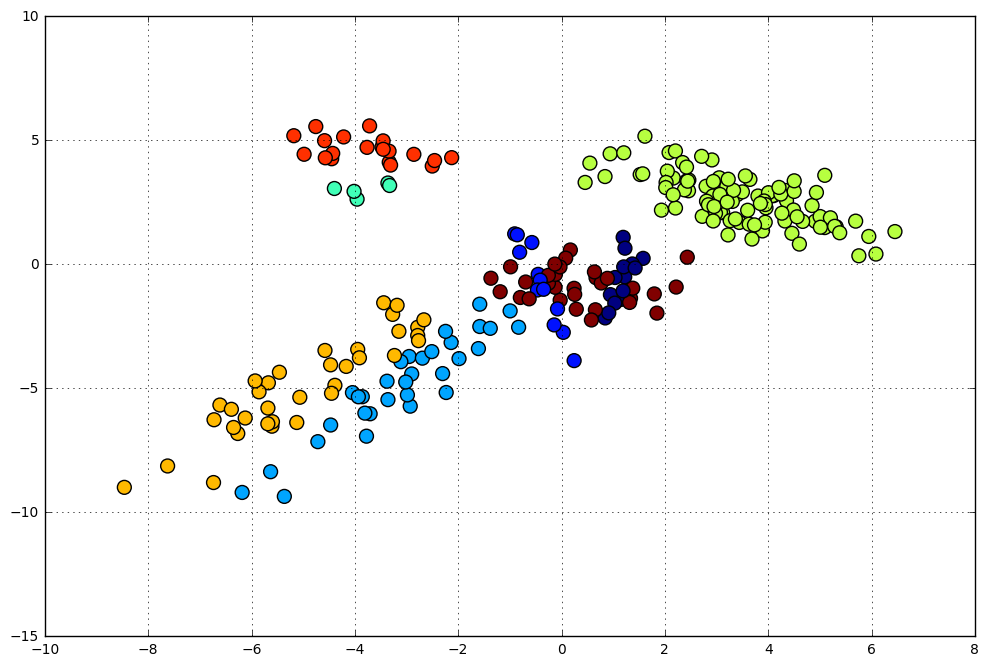

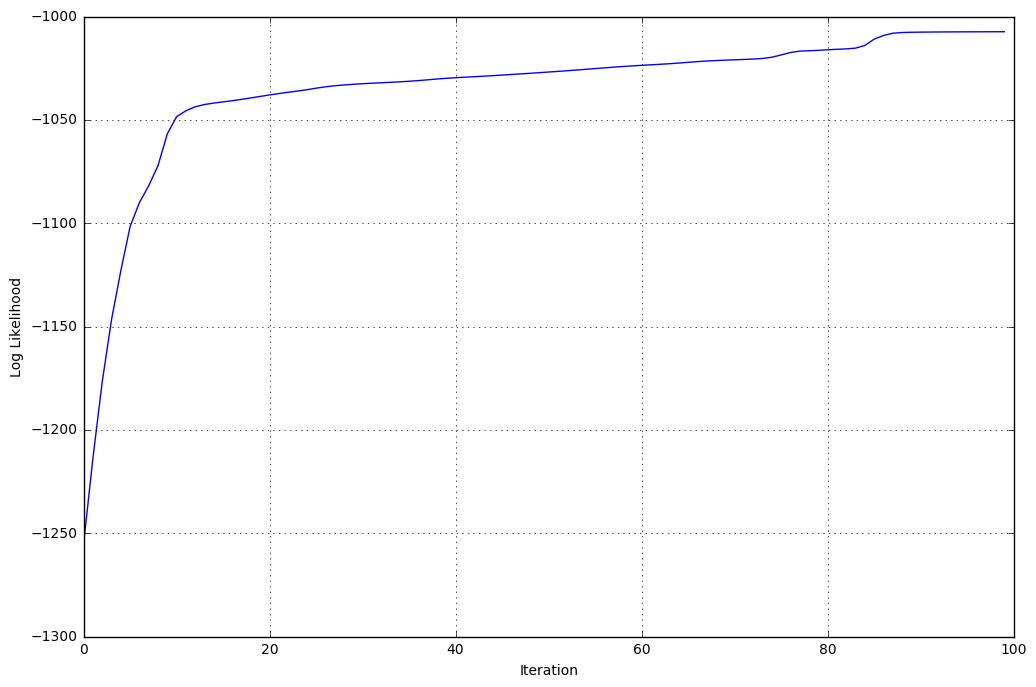

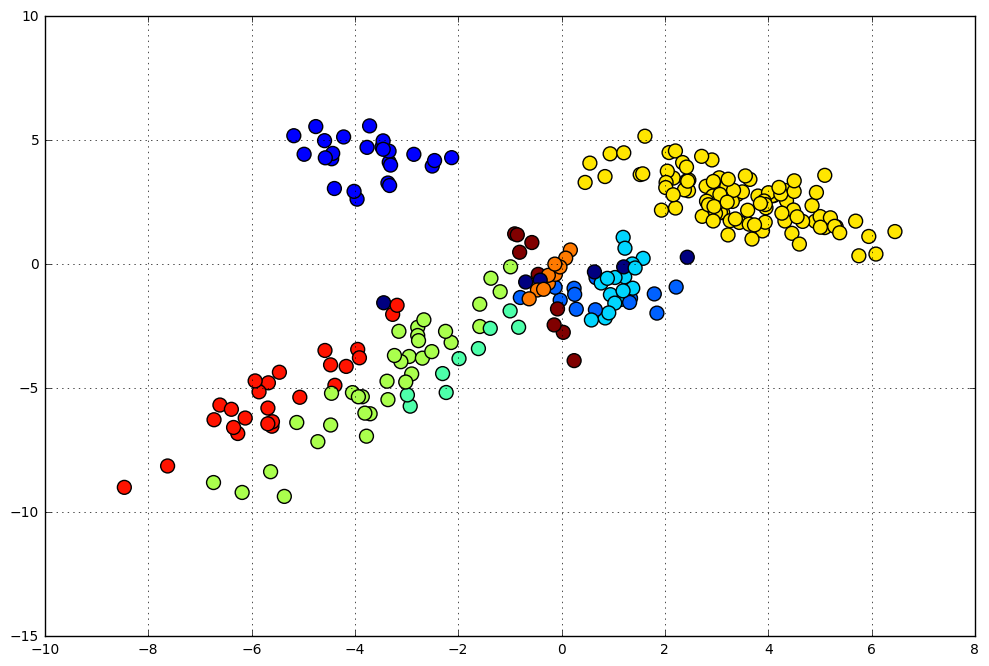

In [24]:
for k in [2, 4, 8, 10]:
    model = GMM()
    model.EM(k=k, X=X, T=100)
    model.EM_plot_loglikelihood()
    model.EM_scatter_plot()

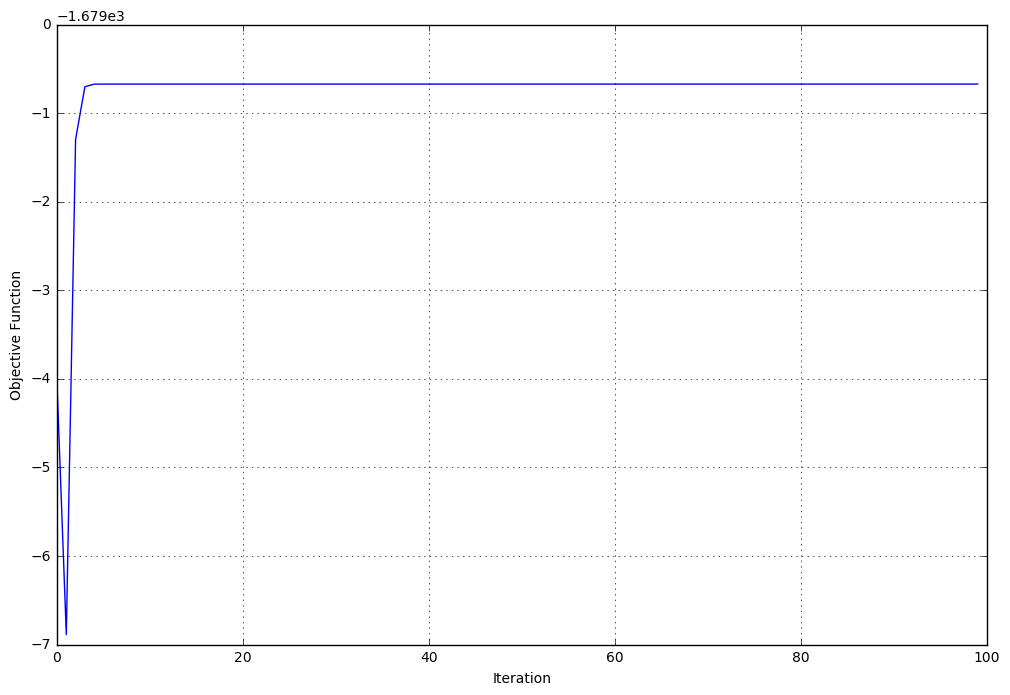

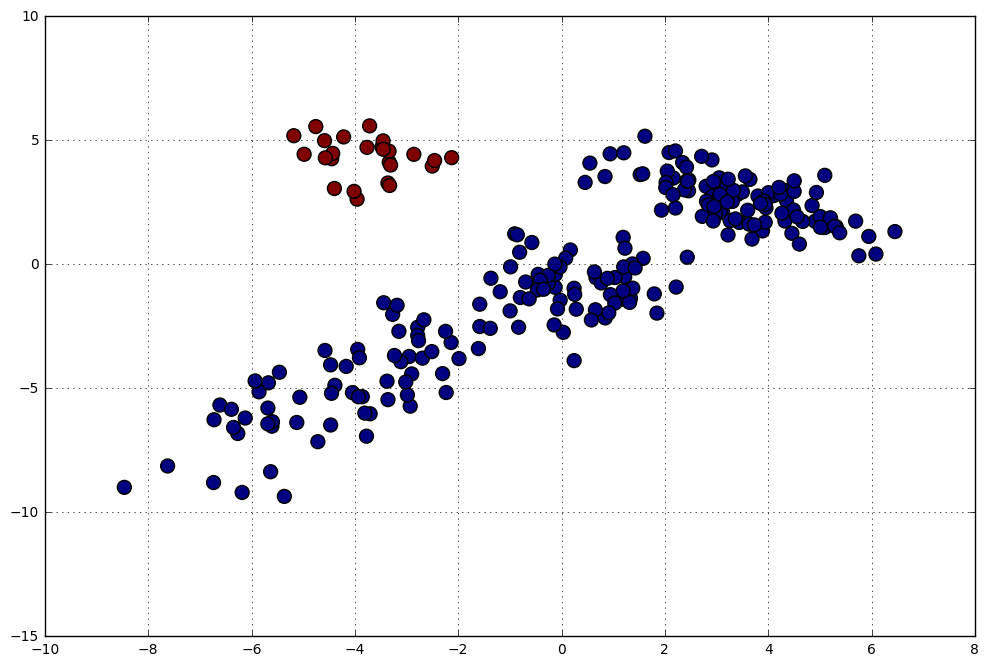

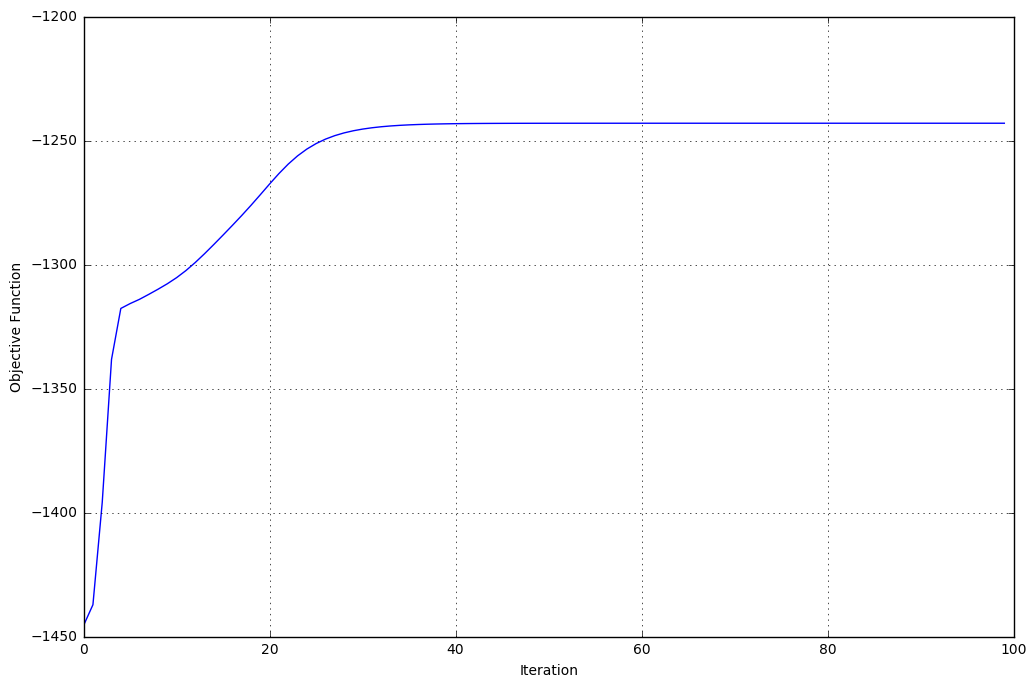

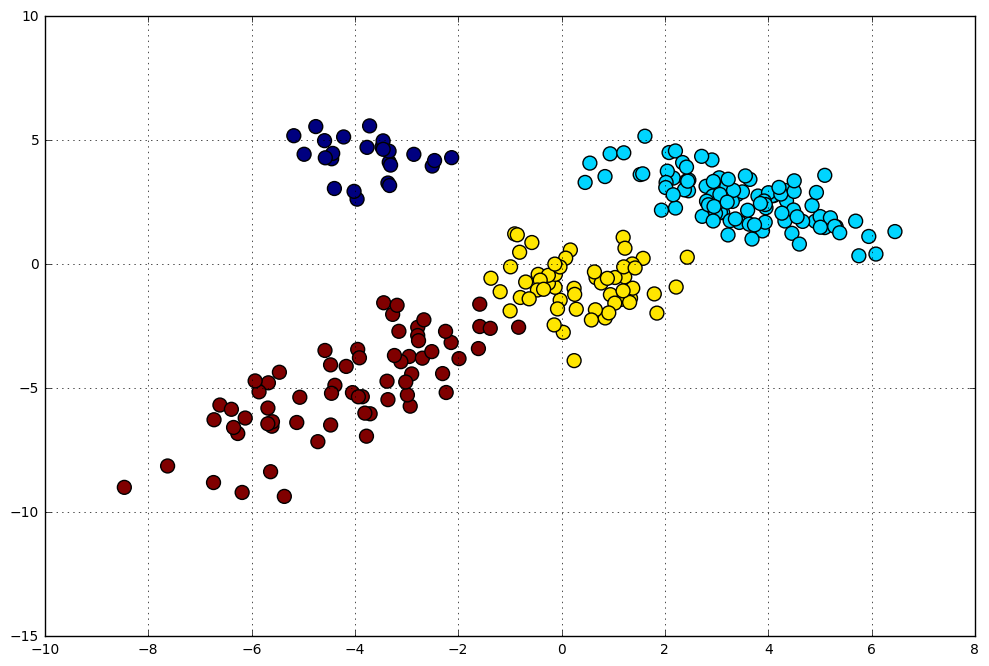

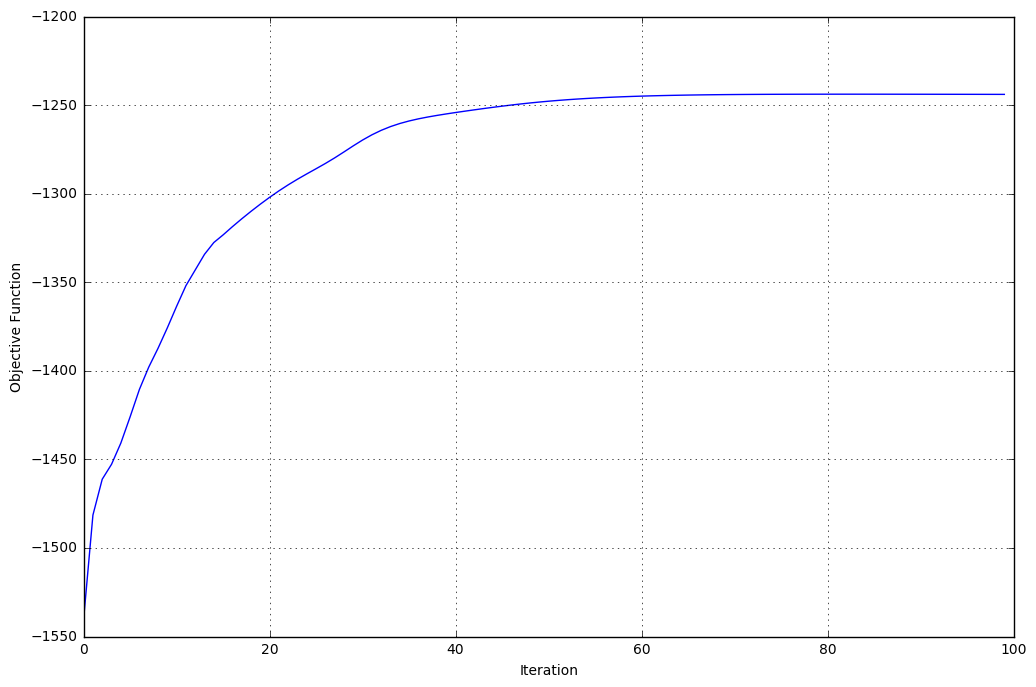

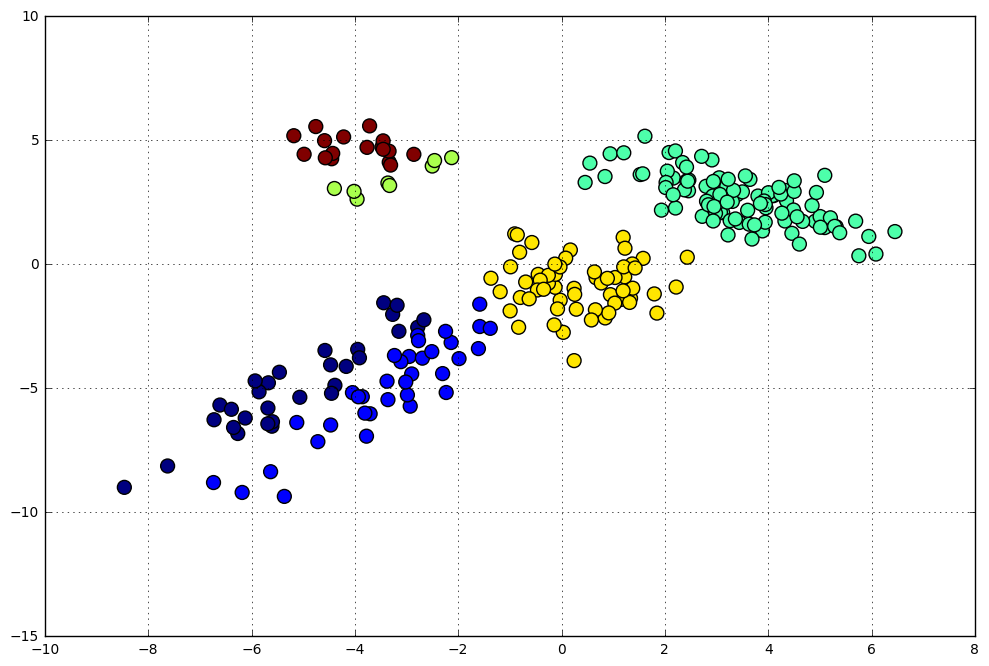

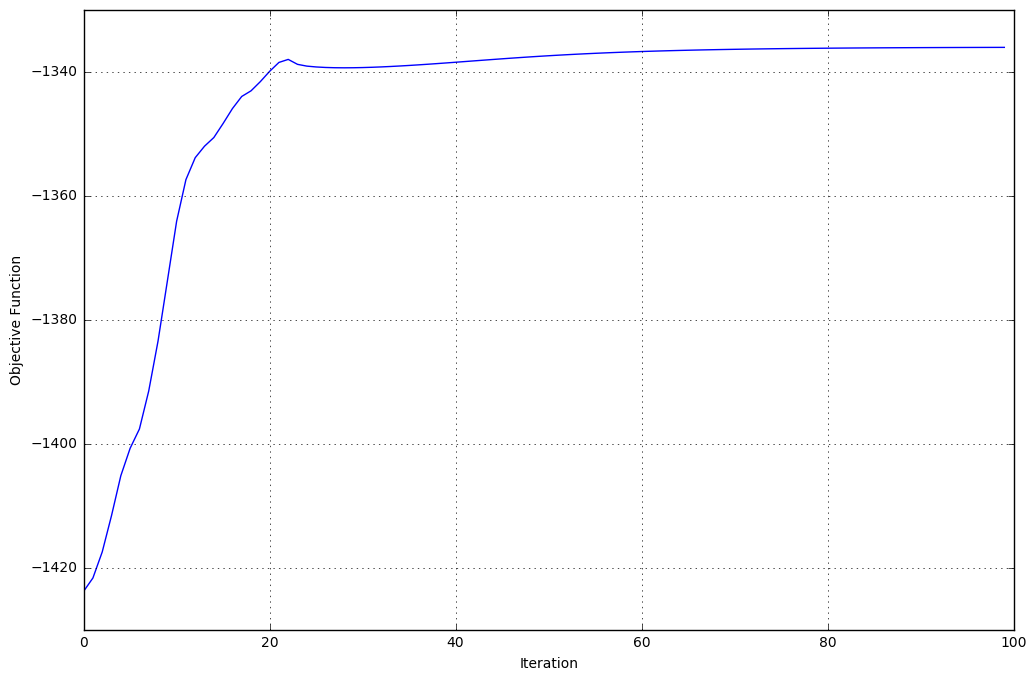

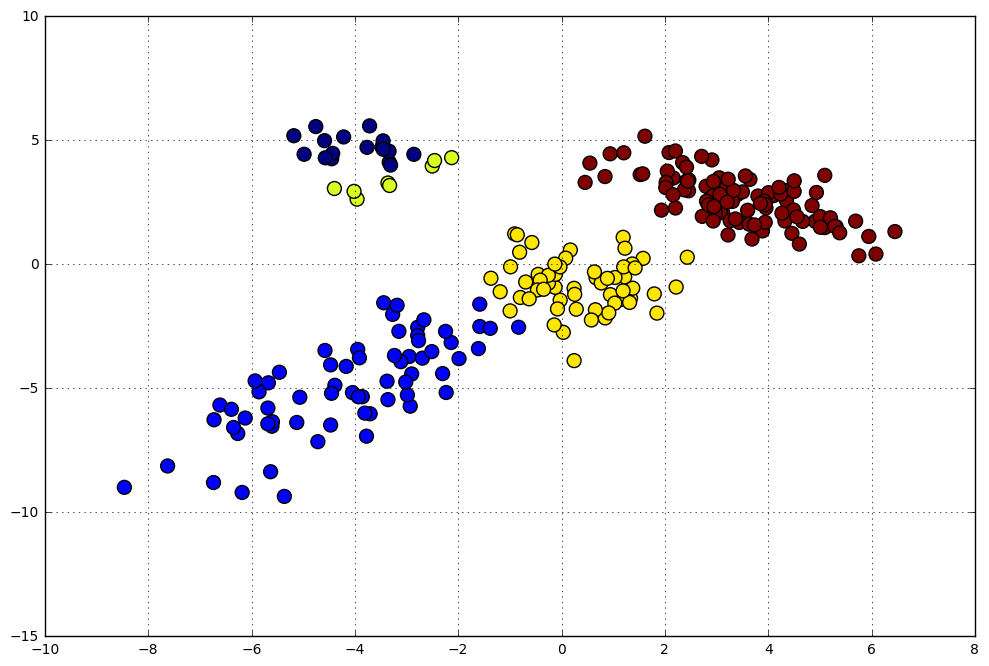

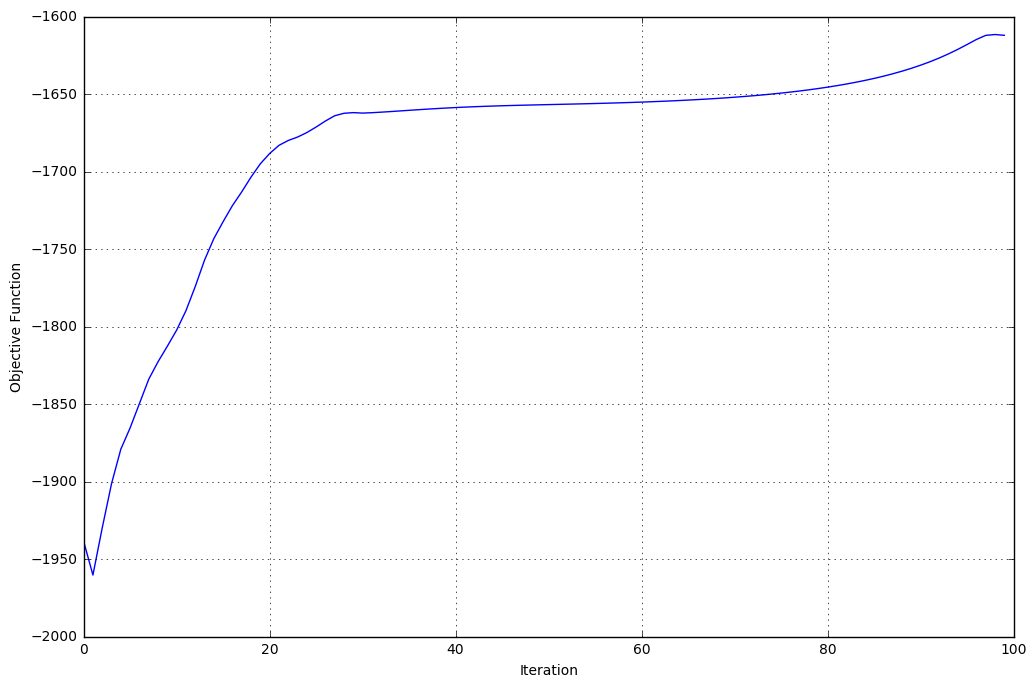

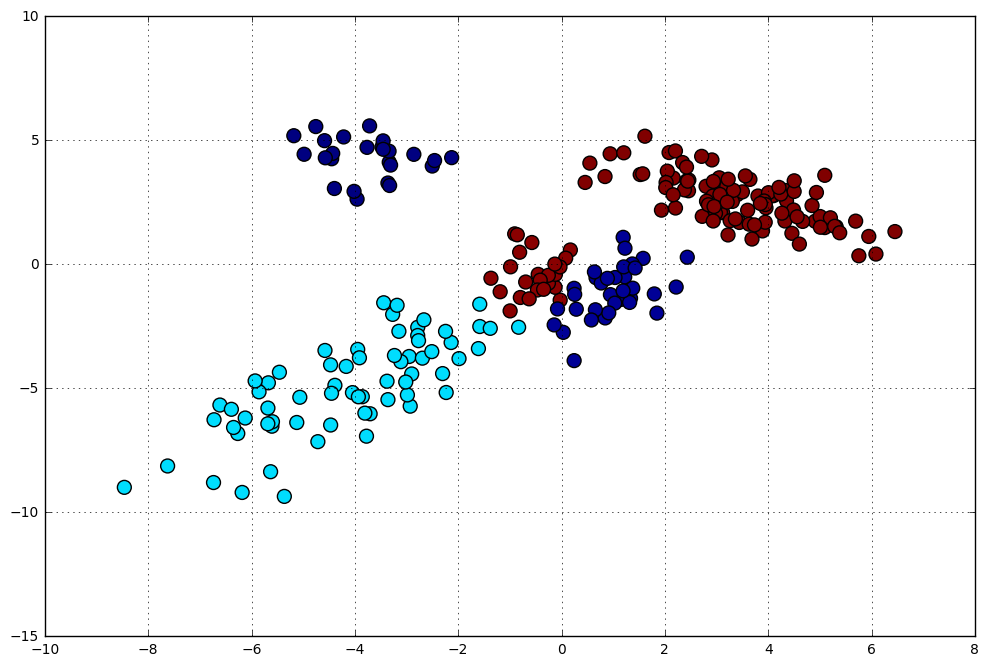

In [25]:
for k in [2, 4, 10, 25, 100]:
    model = GMM()
    model.VI(k=k, X=X, T=100)
    model.VI_plot_objective()
    model.VI_scatter_plot()

In [26]:
model = GMM()
model.Gibbs_Sampler(X)

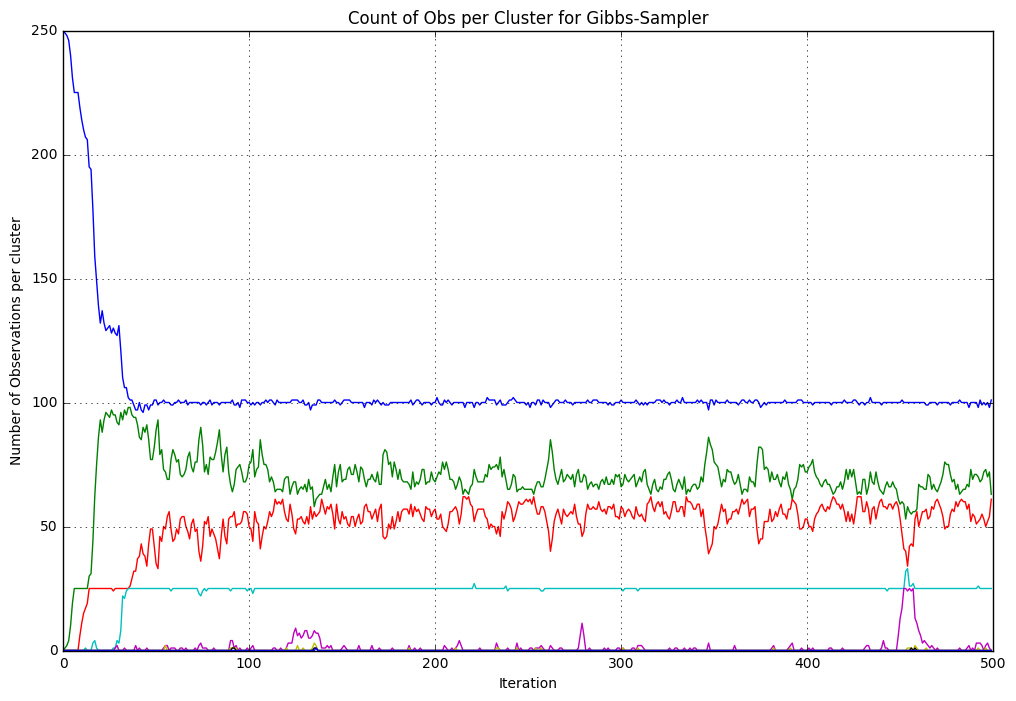

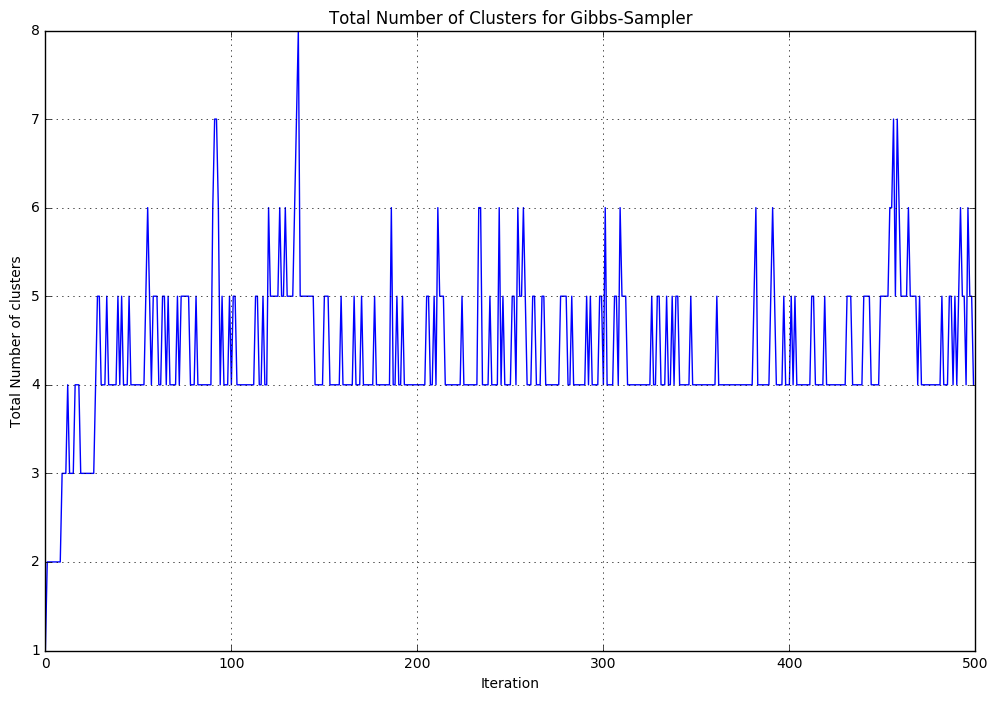

In [27]:
model.plot_ClusterCount()
model.plot_TotalClusters()